# Task 3: Correlation between News Sentiment and Stock Movement


In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Sentiment analysis libraries
try:
    from textblob import TextBlob
    print("✓ TextBlob imported successfully")
except ImportError:
    print("⚠️  TextBlob not found. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "textblob"])
    from textblob import TextBlob
    print("✓ TextBlob installed and imported")

try:
    import nltk
    # Download required NLTK data
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt', quiet=True)
    print("✓ NLTK imported successfully")
except ImportError:
    print("⚠️  NLTK not found. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk"])
    import nltk
    nltk.download('punkt', quiet=True)
    print("✓ NLTK installed and imported")

# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

print("=" * 70)
print("TASK 3: SENTIMENT ANALYSIS AND CORRELATION WITH STOCK MOVEMENTS")
print("=" * 70)
print("All imports successful! ✓")


✓ TextBlob imported successfully
✓ NLTK imported successfully
TASK 3: SENTIMENT ANALYSIS AND CORRELATION WITH STOCK MOVEMENTS
All imports successful! ✓


## 1. Load and Prepare News Data


In [19]:
# Load news data
print("\n1. LOADING NEWS DATA")
print("-" * 70)

RAW_DATA = Path("data/raw/raw_analyst_ratings.csv")
POSSIBLE_PATHS = [
    Path("data/raw/raw_analyst_ratings.csv"),
    Path("../data/raw/raw_analyst_ratings.csv"),
]

def resolve_data_path(possible_paths) -> Path:
    """Return the first existing path for the dataset."""
    cwd = Path.cwd().resolve()
    for relative_path in possible_paths:
        for base in [cwd, *cwd.parents]:
            candidate = base / relative_path
            if candidate.exists():
                return candidate
    return None

data_path = resolve_data_path(POSSIBLE_PATHS)

if data_path:
    try:
        news_df = pd.read_csv(
            data_path,
            encoding_errors="replace",
            on_bad_lines="skip",
            low_memory=False
        )
        print(f"✓ Loaded news data from {data_path}")
        print(f"✓ Dataset shape: {news_df.shape[0]:,} rows × {news_df.shape[1]} columns")
    except Exception as e:
        print(f"✗ Error reading file: {e}")
        raise
else:
    print("✗ News data file not found!")
    raise FileNotFoundError("Please ensure data/raw/raw_analyst_ratings.csv exists")

# Display basic info
print(f"\nColumns: {list(news_df.columns)}")
print(f"\nFirst few rows:")
print(news_df.head())



1. LOADING NEWS DATA
----------------------------------------------------------------------
✓ Loaded news data from C:\project\kifya\Week1\data\raw\raw_analyst_ratings.csv
✓ Dataset shape: 1,407,328 rows × 6 columns

Columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']

First few rows:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...      

In [20]:
# Clean and prepare news data
print("\n2. PREPARING NEWS DATA")
print("-" * 70)

# Convert date column to datetime
news_df['date'] = pd.to_datetime(news_df['date'], utc=True, format='mixed', errors='coerce')

# Fill missing values
news_df['headline'] = news_df['headline'].fillna("")
news_df['stock'] = news_df['stock'].fillna("UNKNOWN")
news_df['publisher'] = news_df['publisher'].fillna("Unknown")

# Extract date only (normalize to date, removing time component)
news_df['date_only'] = news_df['date'].dt.date

# Filter out rows with missing dates or headlines
initial_count = len(news_df)
news_df = news_df.dropna(subset=['date', 'headline'])
news_df = news_df[news_df['headline'].str.strip() != ""]

print(f"✓ Removed {initial_count - len(news_df):,} rows with missing data")
print(f"✓ Remaining rows: {len(news_df):,}")

# Show date range
print(f"\nDate range: {news_df['date'].min()} to {news_df['date'].max()}")
print(f"Unique stocks: {news_df['stock'].nunique()}")
print(f"Stocks: {sorted(news_df['stock'].unique())[:20]}...")  # Show first 20



2. PREPARING NEWS DATA
----------------------------------------------------------------------
✓ Removed 0 rows with missing data
✓ Remaining rows: 1,407,328

Date range: 2009-02-14 00:00:00+00:00 to 2020-06-11 21:12:35+00:00
Unique stocks: 6204
Stocks: ['A', 'AA', 'AAC', 'AADR', 'AAL', 'AAMC', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAU', 'AAV', 'AAVL', 'AAWW', 'AAXJ', 'AB', 'ABAC', 'ABAX']...


## 2. Perform Sentiment Analysis on Headlines


In [21]:
# Perform sentiment analysis
print("\n3. PERFORMING SENTIMENT ANALYSIS")
print("-" * 70)

def analyze_sentiment(text):
    """
    Analyze sentiment of a text using TextBlob.
    Returns: (polarity, subjectivity)
    - Polarity: [-1, 1] where -1 is negative, 1 is positive
    - Subjectivity: [0, 1] where 0 is objective, 1 is subjective
    """
    if not text or pd.isna(text):
        return 0.0, 0.0
    
    try:
        blob = TextBlob(str(text))
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except Exception as e:
        # Return neutral sentiment if analysis fails
        return 0.0, 0.0

# Apply sentiment analysis (this may take a while for large datasets)
print("Analyzing sentiment for all headlines...")
print("This may take a few minutes for large datasets...")

# Process in batches to show progress
batch_size = 10000
total_batches = (len(news_df) // batch_size) + 1

sentiment_results = []
for i in range(0, len(news_df), batch_size):
    batch = news_df.iloc[i:i+batch_size]
    batch_sentiments = batch['headline'].apply(analyze_sentiment)
    sentiment_results.extend(batch_sentiments)
    
    if (i // batch_size + 1) % 10 == 0 or i + batch_size >= len(news_df):
        print(f"  Processed {min(i+batch_size, len(news_df)):,} / {len(news_df):,} headlines...")

# Extract polarity and subjectivity
news_df['sentiment_polarity'] = [s[0] for s in sentiment_results]
news_df['sentiment_subjectivity'] = [s[1] for s in sentiment_results]

# Classify sentiment
news_df['sentiment_label'] = news_df['sentiment_polarity'].apply(
    lambda x: 'positive' if x > 0.1 else ('negative' if x < -0.1 else 'neutral')
)

print(f"\n✓ Sentiment analysis complete!")
print(f"\nSentiment distribution:")
print(news_df['sentiment_label'].value_counts())
print(f"\nSentiment statistics:")
print(news_df['sentiment_polarity'].describe())



3. PERFORMING SENTIMENT ANALYSIS
----------------------------------------------------------------------
Analyzing sentiment for all headlines...
This may take a few minutes for large datasets...
  Processed 100,000 / 1,407,328 headlines...
  Processed 200,000 / 1,407,328 headlines...
  Processed 300,000 / 1,407,328 headlines...
  Processed 400,000 / 1,407,328 headlines...
  Processed 500,000 / 1,407,328 headlines...
  Processed 600,000 / 1,407,328 headlines...
  Processed 700,000 / 1,407,328 headlines...
  Processed 800,000 / 1,407,328 headlines...
  Processed 900,000 / 1,407,328 headlines...
  Processed 1,000,000 / 1,407,328 headlines...
  Processed 1,100,000 / 1,407,328 headlines...
  Processed 1,200,000 / 1,407,328 headlines...
  Processed 1,300,000 / 1,407,328 headlines...
  Processed 1,400,000 / 1,407,328 headlines...
  Processed 1,407,328 / 1,407,328 headlines...

✓ Sentiment analysis complete!

Sentiment distribution:
sentiment_label
neutral     1046537
positive     269878
nega

✓ Saved sentiment distribution plot to reports/figures/sentiment_distribution.png


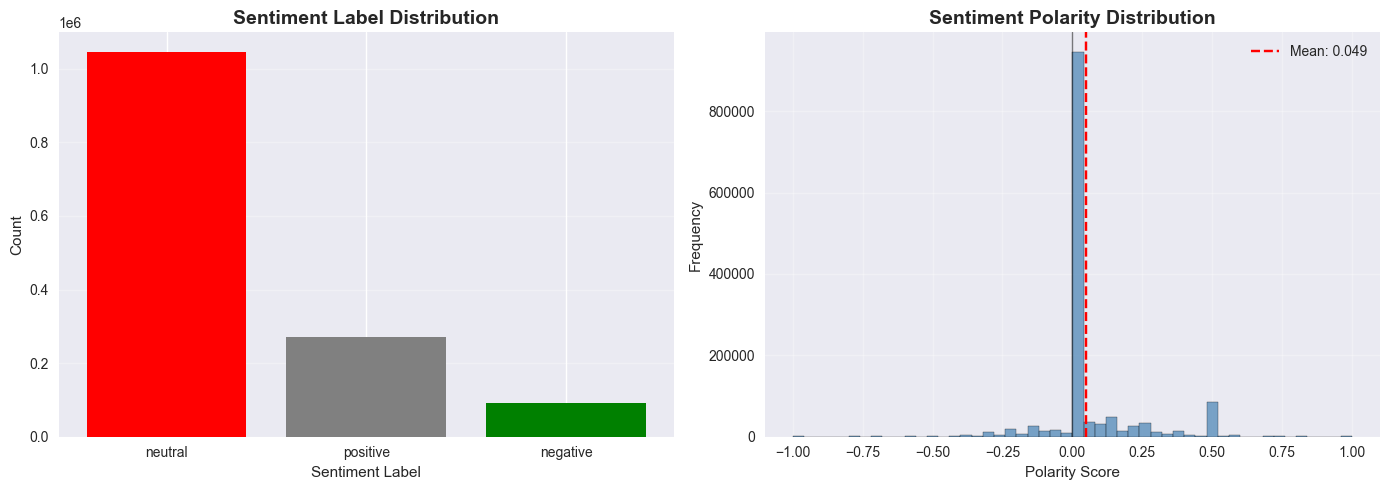

In [22]:
# Visualize sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sentiment label distribution
sentiment_counts = news_df['sentiment_label'].value_counts()
axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'gray', 'green'])
axes[0].set_title('Sentiment Label Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment Label')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Sentiment polarity distribution
axes[1].hist(news_df['sentiment_polarity'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(news_df['sentiment_polarity'].mean(), color='red', linestyle='--', 
                label=f'Mean: {news_df["sentiment_polarity"].mean():.3f}')
axes[1].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1].set_title('Sentiment Polarity Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Polarity Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('reports/figures/sentiment_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved sentiment distribution plot to reports/figures/sentiment_distribution.png")
plt.show()


## 3. Load and Prepare Stock Price Data


In [23]:
# Load stock price data
print("\n4. LOADING STOCK PRICE DATA")
print("-" * 70)

PRICE_DIR_CANDIDATES = [
    Path("data/processed/prices"),
    Path("../data/processed/prices"),
    Path("../../data/processed/prices")
]

PRICE_DIR = resolve_data_path(PRICE_DIR_CANDIDATES)
if PRICE_DIR is None:
    raise FileNotFoundError("Unable to locate the processed price directory. Please ensure data/processed/prices exists.")

STOCKS_TO_ANALYZE = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']

stock_data = {}
for stock in STOCKS_TO_ANALYZE:
    price_file = PRICE_DIR / f"{stock}.csv"
    if price_file.exists():
        try:
            df = pd.read_csv(price_file, parse_dates=["Date"])
            df = df.sort_values("Date").set_index("Date")
            # Ensure numeric columns
            numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
            df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
            df = df.dropna(subset=["Close"])
            stock_data[stock] = df
            print(f"✓ {stock}: {len(df):,} trading days ({df.index.min().date()} to {df.index.max().date()})")
        except Exception as e:
            print(f"✗ {stock}: Error loading - {e}")
    else:
        print(f"✗ {stock}: File not found at {price_file}")

print(f"\n✓ Loaded {len(stock_data)} stock datasets")



4. LOADING STOCK PRICE DATA
----------------------------------------------------------------------
✓ AAPL: 3,774 trading days (2009-01-02 to 2023-12-29)
✓ AMZN: 3,774 trading days (2009-01-02 to 2023-12-29)
✓ GOOG: 3,774 trading days (2009-01-02 to 2023-12-29)
✓ META: 2,923 trading days (2012-05-18 to 2023-12-29)
✓ MSFT: 3,774 trading days (2009-01-02 to 2023-12-29)
✓ NVDA: 3,774 trading days (2009-01-02 to 2023-12-29)

✓ Loaded 6 stock datasets


In [24]:
# Calculate daily returns for each stock
print("\n5. CALCULATING DAILY STOCK RETURNS")
print("-" * 70)

stock_returns = {}
for stock, df in stock_data.items():
    # Calculate daily percentage return
    df['daily_return'] = df['Close'].pct_change() * 100  # Convert to percentage
    df['daily_return'] = df['daily_return'].fillna(0)  # First day has no return
    
    # Create a dataframe with date and return
    returns_df = pd.DataFrame({
        'date': df.index.date,
        'daily_return': df['daily_return'],
        'close_price': df['Close']
    })
    returns_df['date'] = pd.to_datetime(returns_df['date'])
    
    stock_returns[stock] = returns_df
    print(f"✓ {stock}: Mean return = {returns_df['daily_return'].mean():.4f}%, "
          f"Std = {returns_df['daily_return'].std():.4f}%")

print(f"\n✓ Calculated returns for {len(stock_returns)} stocks")



5. CALCULATING DAILY STOCK RETURNS
----------------------------------------------------------------------
✓ AAPL: Mean return = 0.1289%, Std = 1.8008%
✓ AMZN: Mean return = 0.1302%, Std = 2.1826%
✓ GOOG: Mean return = 0.0910%, Std = 1.7331%
✓ META: Mean return = 0.1082%, Std = 2.5276%
✓ MSFT: Mean return = 0.0995%, Std = 1.6883%
✓ NVDA: Mean return = 0.1876%, Std = 2.8913%

✓ Calculated returns for 6 stocks


## 4. Align Dates and Aggregate Daily Sentiment


In [25]:
# Aggregate daily sentiment scores by stock
print("\n6. AGGREGATING DAILY SENTIMENT SCORES")
print("-" * 70)

# Group by stock and date, then aggregate sentiment
daily_sentiment_raw = news_df.groupby(['stock', 'date_only']).agg({
    'sentiment_polarity': ['mean', 'std', 'count'],
    'sentiment_subjectivity': 'mean'
}).reset_index()

# Flatten column names
daily_sentiment_raw.columns = ['stock', 'date', 'avg_sentiment', 'sentiment_std', 'article_count', 'avg_subjectivity']
daily_sentiment_raw['date'] = pd.to_datetime(daily_sentiment_raw['date'])

# Fill NaN std values (when only one article per day)
daily_sentiment_raw['sentiment_std'] = daily_sentiment_raw['sentiment_std'].fillna(0)

print(f"✓ Aggregated sentiment for {len(daily_sentiment_raw):,} stock-date combinations")
print(f"\nSample aggregated data:")
print(daily_sentiment_raw.head(10))



6. AGGREGATING DAILY SENTIMENT SCORES
----------------------------------------------------------------------
✓ Aggregated sentiment for 842,010 stock-date combinations

Sample aggregated data:
  stock       date  avg_sentiment  sentiment_std  article_count  \
0     A 2009-04-29       0.000000       0.000000              1   
1     A 2009-06-01       0.000000       0.000000              1   
2     A 2009-07-14       0.000000       0.000000              1   
3     A 2009-07-30       0.000000       0.000000              1   
4     A 2009-08-04       0.000000       0.000000              1   
5     A 2009-08-06       0.067857       0.140471              7   
6     A 2009-08-07       0.083765       0.236995             80   
7     A 2009-08-08      -0.050000       0.000000              1   
8     A 2009-08-09       0.163571       0.186329              8   
9     A 2009-08-10       0.061928       0.162151            151   

   avg_subjectivity  
0          0.000000  
1          0.000000  
2 

## 4a. Normalize News Dates to Trading Days

Align the aggregated news sentiment dates to the actual trading calendar for each stock. News published on weekends or market holidays is forward-filled to the next available trading day so that sentiment can be compared fairly against realized returns.


In [26]:
print("\n6A. NORMALIZING SENTIMENT DATES TO TRADING CALENDAR")
print("-" * 70)

MAX_FORWARD_DAYS = 3  # tolerate weekend/holiday gaps

def align_sentiment_to_trading_days(sentiment_df, returns_lookup, max_forward_days=MAX_FORWARD_DAYS):
    """Forward-fill news sentiment to the next valid trading day per stock."""
    aligned_frames = []
    summary_rows = []

    for stock, returns_df in returns_lookup.items():
        stock_sent = sentiment_df[sentiment_df['stock'] == stock].copy()
        if stock_sent.empty:
            summary_rows.append({
                'stock': stock,
                'news_rows': 0,
                'matched_rows': 0,
                'forward_filled_rows': 0,
                'rows_dropped': 0
            })
            continue

        trading_dates = returns_df['date'].dt.normalize().drop_duplicates().sort_values()
        if trading_dates.empty:
            summary_rows.append({
                'stock': stock,
                'news_rows': len(stock_sent),
                'matched_rows': 0,
                'forward_filled_rows': 0,
                'rows_dropped': len(stock_sent)
            })
            continue

        trading_np = trading_dates.values.astype('datetime64[ns]')
        stock_sent = stock_sent.sort_values('date').reset_index(drop=True)
        news_np = stock_sent['date'].values.astype('datetime64[ns]')
        insertion_points = np.searchsorted(trading_np, news_np, side='left')

        aligned_dates = []
        forward_fill_flags = []
        for original_date, idx in zip(stock_sent['date'], insertion_points):
            if idx >= len(trading_np):
                aligned_dates.append(pd.NaT)
                forward_fill_flags.append(False)
                continue

            candidate = pd.Timestamp(trading_np[idx])
            delta_days = (candidate - original_date.normalize()).days
            if delta_days > max_forward_days:
                aligned_dates.append(pd.NaT)
                forward_fill_flags.append(False)
                continue

            aligned_dates.append(candidate)
            forward_fill_flags.append(delta_days > 0)

        stock_sent['news_date'] = stock_sent['date']
        stock_sent['date'] = aligned_dates
        stock_sent['forward_filled'] = forward_fill_flags

        dropped_rows = stock_sent['date'].isna().sum()
        stock_sent = stock_sent.dropna(subset=['date'])

        aligned_frames.append(stock_sent)
        summary_rows.append({
            'stock': stock,
            'news_rows': len(stock_sent) + dropped_rows,
            'matched_rows': len(stock_sent),
            'forward_filled_rows': int(stock_sent['forward_filled'].sum()),
            'rows_dropped': int(dropped_rows)
        })

    if not aligned_frames:
        return pd.DataFrame(columns=sentiment_df.columns), pd.DataFrame(summary_rows)

    aligned_df = pd.concat(aligned_frames, ignore_index=True)
    aligned_df['date'] = pd.to_datetime(aligned_df['date'])
    aligned_df['news_date'] = pd.to_datetime(aligned_df['news_date'])
    return aligned_df, pd.DataFrame(summary_rows)


daily_sentiment_aligned, alignment_summary = align_sentiment_to_trading_days(
    daily_sentiment_raw,
    stock_returns
)

print(f"✓ Alignment complete for {len(daily_sentiment_aligned):,} stock-date pairs")
if not alignment_summary.empty:
    total_forward = alignment_summary['forward_filled_rows'].sum()
    total_dropped = alignment_summary['rows_dropped'].sum()
    print(f"  Forward-filled rows: {total_forward:,}")
    print(f"  Dropped rows (no trading day within {MAX_FORWARD_DAYS}d): {total_dropped:,}")
    display(alignment_summary)




6A. NORMALIZING SENTIMENT DATES TO TRADING CALENDAR
----------------------------------------------------------------------
✓ Alignment complete for 1,691 stock-date pairs
  Forward-filled rows: 125
  Dropped rows (no trading day within 3d): 0


,stock,news_rows,matched_rows,forward_filled_rows,rows_dropped
0,AAPL,80,80,19,0
1,AMZN,37,37,9,0
2,GOOG,377,377,25,0
3,META,0,0,0,0
4,MSFT,0,0,0,0
5,NVDA,1197,1197,72,0


In [27]:
# Merge sentiment with stock returns for each stock
print("\n7. ALIGNING DATES AND MERGING DATA")
print("-" * 70)

correlation_results = []
merged_data_all = {}

for stock in STOCKS_TO_ANALYZE:
    if stock not in stock_returns:
        print(f"⚠️  Skipping {stock}: No price data available")
        continue
    
    # Get stock returns
    returns_df = stock_returns[stock].copy()
    
    # Get aligned sentiment for this stock (handle different stock symbol formats)
    stock_sentiment = daily_sentiment_aligned[daily_sentiment_aligned['stock'] == stock].copy()
    
    if len(stock_sentiment) == 0 and stock == 'GOOG':
        stock_sentiment = daily_sentiment_aligned[daily_sentiment_aligned['stock'] == 'GOOGL'].copy()
    
    if len(stock_sentiment) == 0:
        print(f"⚠️  {stock}: No aligned sentiment data found")
        continue
    
    # Merge on aligned trading date
    merged = pd.merge(
        returns_df,
        stock_sentiment[['date', 'news_date', 'avg_sentiment', 'article_count', 'avg_subjectivity', 'forward_filled']],
        on='date',
        how='inner'  # Only keep dates with both sentiment and returns
    )
    
    if len(merged) == 0:
        print(f"⚠️  {stock}: No overlapping dates between sentiment and returns")
        continue
    
    merged_data_all[stock] = merged
    
    # Calculate correlation
    if len(merged) > 1:  # Need at least 2 data points for correlation
        correlation, p_value = pearsonr(merged['avg_sentiment'], merged['daily_return'])
        correlation_results.append({
            'stock': stock,
            'correlation': correlation,
            'p_value': p_value,
            'n_observations': len(merged),
            'date_range': f"{merged['date'].min().date()} to {merged['date'].max().date()}",
            'forward_fill_share': merged['forward_filled'].mean()
        })
        print(f"✓ {stock}: Correlation = {correlation:.4f} (p={p_value:.4f}), "
              f"N={len(merged):,} days")
    else:
        print(f"⚠️  {stock}: Insufficient data for correlation")

print(f"\n✓ Merged data for {len(merged_data_all)} stocks")



7. ALIGNING DATES AND MERGING DATA
----------------------------------------------------------------------
✓ AAPL: Correlation = 0.0670 (p=0.5548), N=80 days
✓ AMZN: Correlation = 0.0197 (p=0.9079), N=37 days
✓ GOOG: Correlation = 0.1046 (p=0.0424), N=377 days
⚠️  META: No aligned sentiment data found
⚠️  MSFT: No aligned sentiment data found
✓ NVDA: Correlation = 0.0865 (p=0.0027), N=1,197 days

✓ Merged data for 4 stocks


## 5. Correlation Analysis Results


In [28]:
# Display correlation results
print("\n8. CORRELATION ANALYSIS RESULTS")
print("=" * 70)

if correlation_results:
    results_df = pd.DataFrame(correlation_results)
    results_df = results_df.sort_values('correlation', ascending=False)
    
    print("\nCorrelation between Daily Sentiment and Stock Returns:")
    print(results_df.to_string(index=False))
    
    # Save results
    output_dir = Path("data/processed/sentiment_correlation")
    output_dir.mkdir(parents=True, exist_ok=True)
    results_df.to_csv(output_dir / "correlation_results.csv", index=False)
    print(f"\n✓ Saved correlation results to {output_dir / 'correlation_results.csv'}")
    
    # Summary statistics
    print(f"\nSummary Statistics:")
    print(f"  Mean correlation: {results_df['correlation'].mean():.4f}")
    print(f"  Median correlation: {results_df['correlation'].median():.4f}")
    print(f"  Std correlation: {results_df['correlation'].std():.4f}")
    print(f"  Significant correlations (p < 0.05): {(results_df['p_value'] < 0.05).sum()}")
    print(f"  Strong correlations (|r| > 0.3): {(results_df['correlation'].abs() > 0.3).sum()}")
else:
    print("⚠️  No correlation results available")



8. CORRELATION ANALYSIS RESULTS

Correlation between Daily Sentiment and Stock Returns:
stock  correlation  p_value  n_observations               date_range  forward_fill_share
 GOOG     0.104568 0.042442             377 2018-11-13 to 2020-06-10            0.066313
 NVDA     0.086545 0.002729            1197 2011-03-03 to 2020-06-10            0.060150
 AAPL     0.067014 0.554775              80 2020-03-09 to 2020-06-10            0.237500
 AMZN     0.019694 0.907897              37 2020-04-27 to 2020-06-10            0.243243

✓ Saved correlation results to data\processed\sentiment_correlation\correlation_results.csv

Summary Statistics:
  Mean correlation: 0.0695
  Median correlation: 0.0768
  Std correlation: 0.0365
  Significant correlations (p < 0.05): 2
  Strong correlations (|r| > 0.3): 0


✓ Saved correlation analysis plot to reports/figures/sentiment_correlation_analysis.png


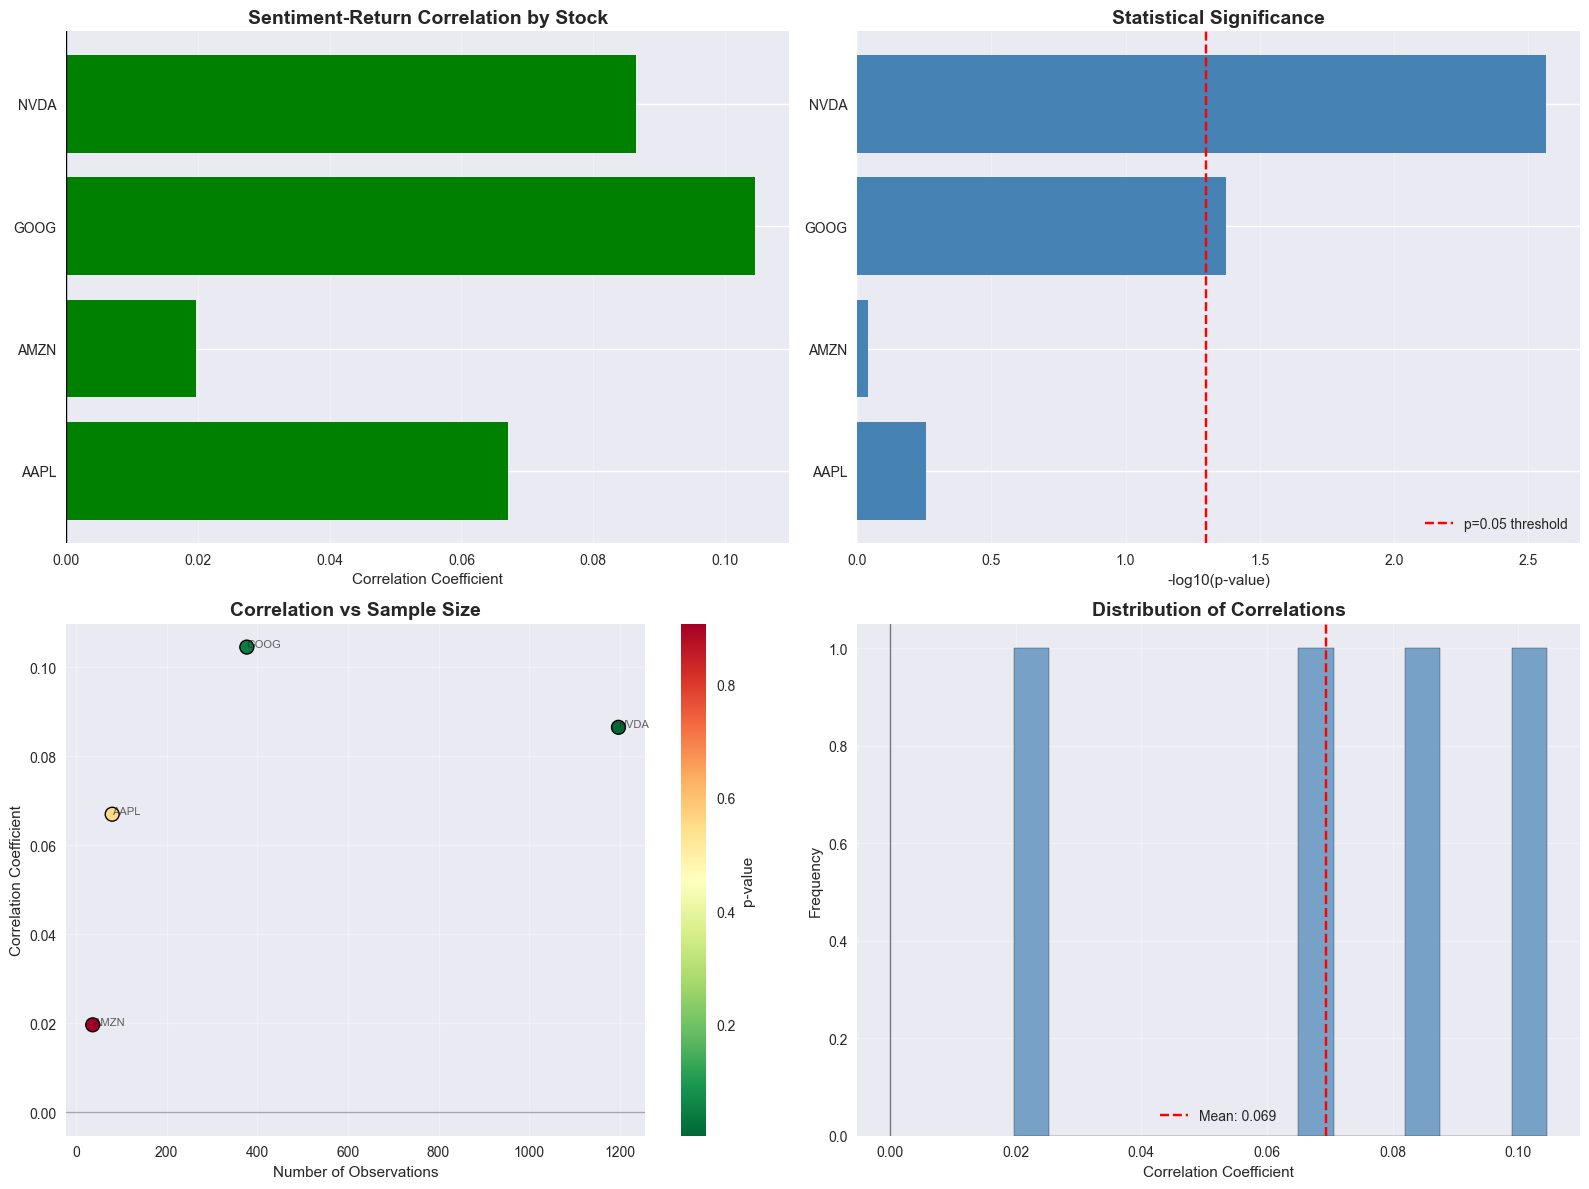

In [29]:
# Visualize correlation results
if correlation_results:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    results_df = pd.DataFrame(correlation_results)
    
    # 1. Bar plot of correlations
    axes[0, 0].barh(results_df['stock'], results_df['correlation'], 
                    color=['green' if x > 0 else 'red' for x in results_df['correlation']])
    axes[0, 0].axvline(0, color='black', linestyle='-', linewidth=1)
    axes[0, 0].set_xlabel('Correlation Coefficient')
    axes[0, 0].set_title('Sentiment-Return Correlation by Stock', fontsize=14, fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # 2. P-value visualization
    axes[0, 1].barh(results_df['stock'], -np.log10(results_df['p_value'] + 1e-10),
                    color='steelblue')
    axes[0, 1].axvline(-np.log10(0.05), color='red', linestyle='--', 
                       label='p=0.05 threshold')
    axes[0, 1].set_xlabel('-log10(p-value)')
    axes[0, 1].set_title('Statistical Significance', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # 3. Scatter plot: Correlation vs Sample Size
    scatter = axes[1, 0].scatter(results_df['n_observations'], results_df['correlation'],
                                s=100, c=results_df['p_value'], cmap='RdYlGn_r',
                                edgecolors='black', linewidth=1)
    axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    axes[1, 0].set_xlabel('Number of Observations')
    axes[1, 0].set_ylabel('Correlation Coefficient')
    axes[1, 0].set_title('Correlation vs Sample Size', fontsize=14, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 0], label='p-value')
    
    # Add stock labels
    for idx, row in results_df.iterrows():
        axes[1, 0].annotate(row['stock'], 
                           (row['n_observations'], row['correlation']),
                           fontsize=8, alpha=0.7)
    
    # 4. Distribution of correlations
    axes[1, 1].hist(results_df['correlation'], bins=15, color='steelblue', 
                    edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(results_df['correlation'].mean(), color='red', 
                       linestyle='--', label=f'Mean: {results_df["correlation"].mean():.3f}')
    axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    axes[1, 1].set_xlabel('Correlation Coefficient')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Correlations', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('reports/figures/sentiment_correlation_analysis.png', dpi=300, bbox_inches='tight')
    print("✓ Saved correlation analysis plot to reports/figures/sentiment_correlation_analysis.png")
    plt.show()


## 6. Detailed Analysis: Sentiment vs Returns for Individual Stocks



9. CREATING DETAILED VISUALIZATIONS
----------------------------------------------------------------------
✓ Saved detailed scatter plots to reports/figures/sentiment_vs_returns_by_stock.png


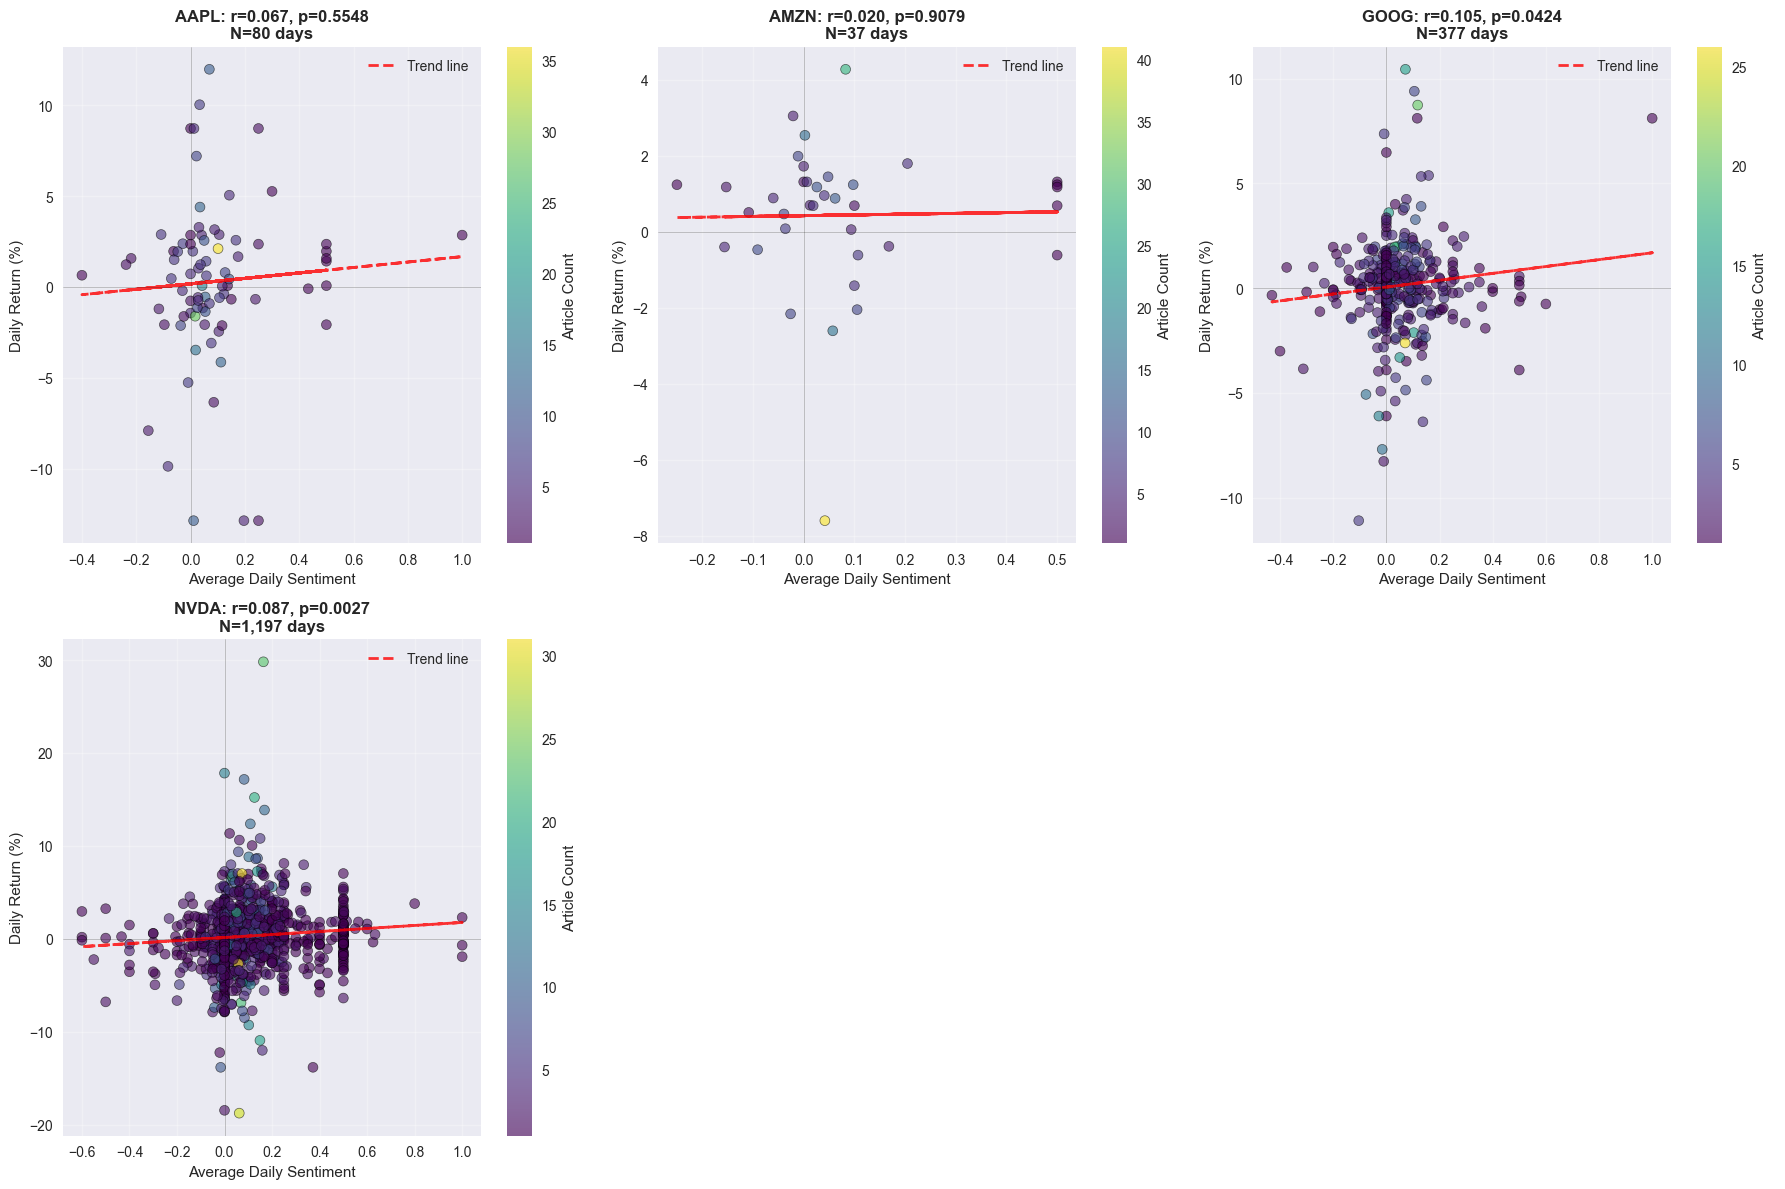

In [30]:
# Create detailed scatter plots for each stock
print("\n9. CREATING DETAILED VISUALIZATIONS")
print("-" * 70)

n_stocks = len(merged_data_all)
if n_stocks > 0:
    cols = 3
    rows = (n_stocks + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
    axes = axes.flatten() if n_stocks > 1 else [axes]
    
    for idx, (stock, merged) in enumerate(merged_data_all.items()):
        ax = axes[idx]
        
        # Scatter plot
        scatter = ax.scatter(merged['avg_sentiment'], merged['daily_return'],
                           alpha=0.6, s=50, c=merged['article_count'],
                           cmap='viridis', edgecolors='black', linewidth=0.5)
        
        # Add trend line
        z = np.polyfit(merged['avg_sentiment'], merged['daily_return'], 1)
        p = np.poly1d(z)
        ax.plot(merged['avg_sentiment'], p(merged['avg_sentiment']), 
               "r--", alpha=0.8, linewidth=2, label=f'Trend line')
        
        # Calculate and display correlation
        corr, p_val = pearsonr(merged['avg_sentiment'], merged['daily_return'])
        ax.set_title(f'{stock}: r={corr:.3f}, p={p_val:.4f}\n'
                    f'N={len(merged):,} days', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Average Daily Sentiment')
        ax.set_ylabel('Daily Return (%)')
        ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
        ax.axvline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
        ax.grid(alpha=0.3)
        ax.legend()
        
        # Add colorbar
        plt.colorbar(scatter, ax=ax, label='Article Count')
    
    # Hide unused subplots
    for idx in range(n_stocks, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('reports/figures/sentiment_vs_returns_by_stock.png', dpi=300, bbox_inches='tight')
    print("✓ Saved detailed scatter plots to reports/figures/sentiment_vs_returns_by_stock.png")
    plt.show()


## 7. Time Series Analysis: Sentiment and Returns Over Time


✓ Saved time series plots to reports/figures/sentiment_returns_timeseries.png


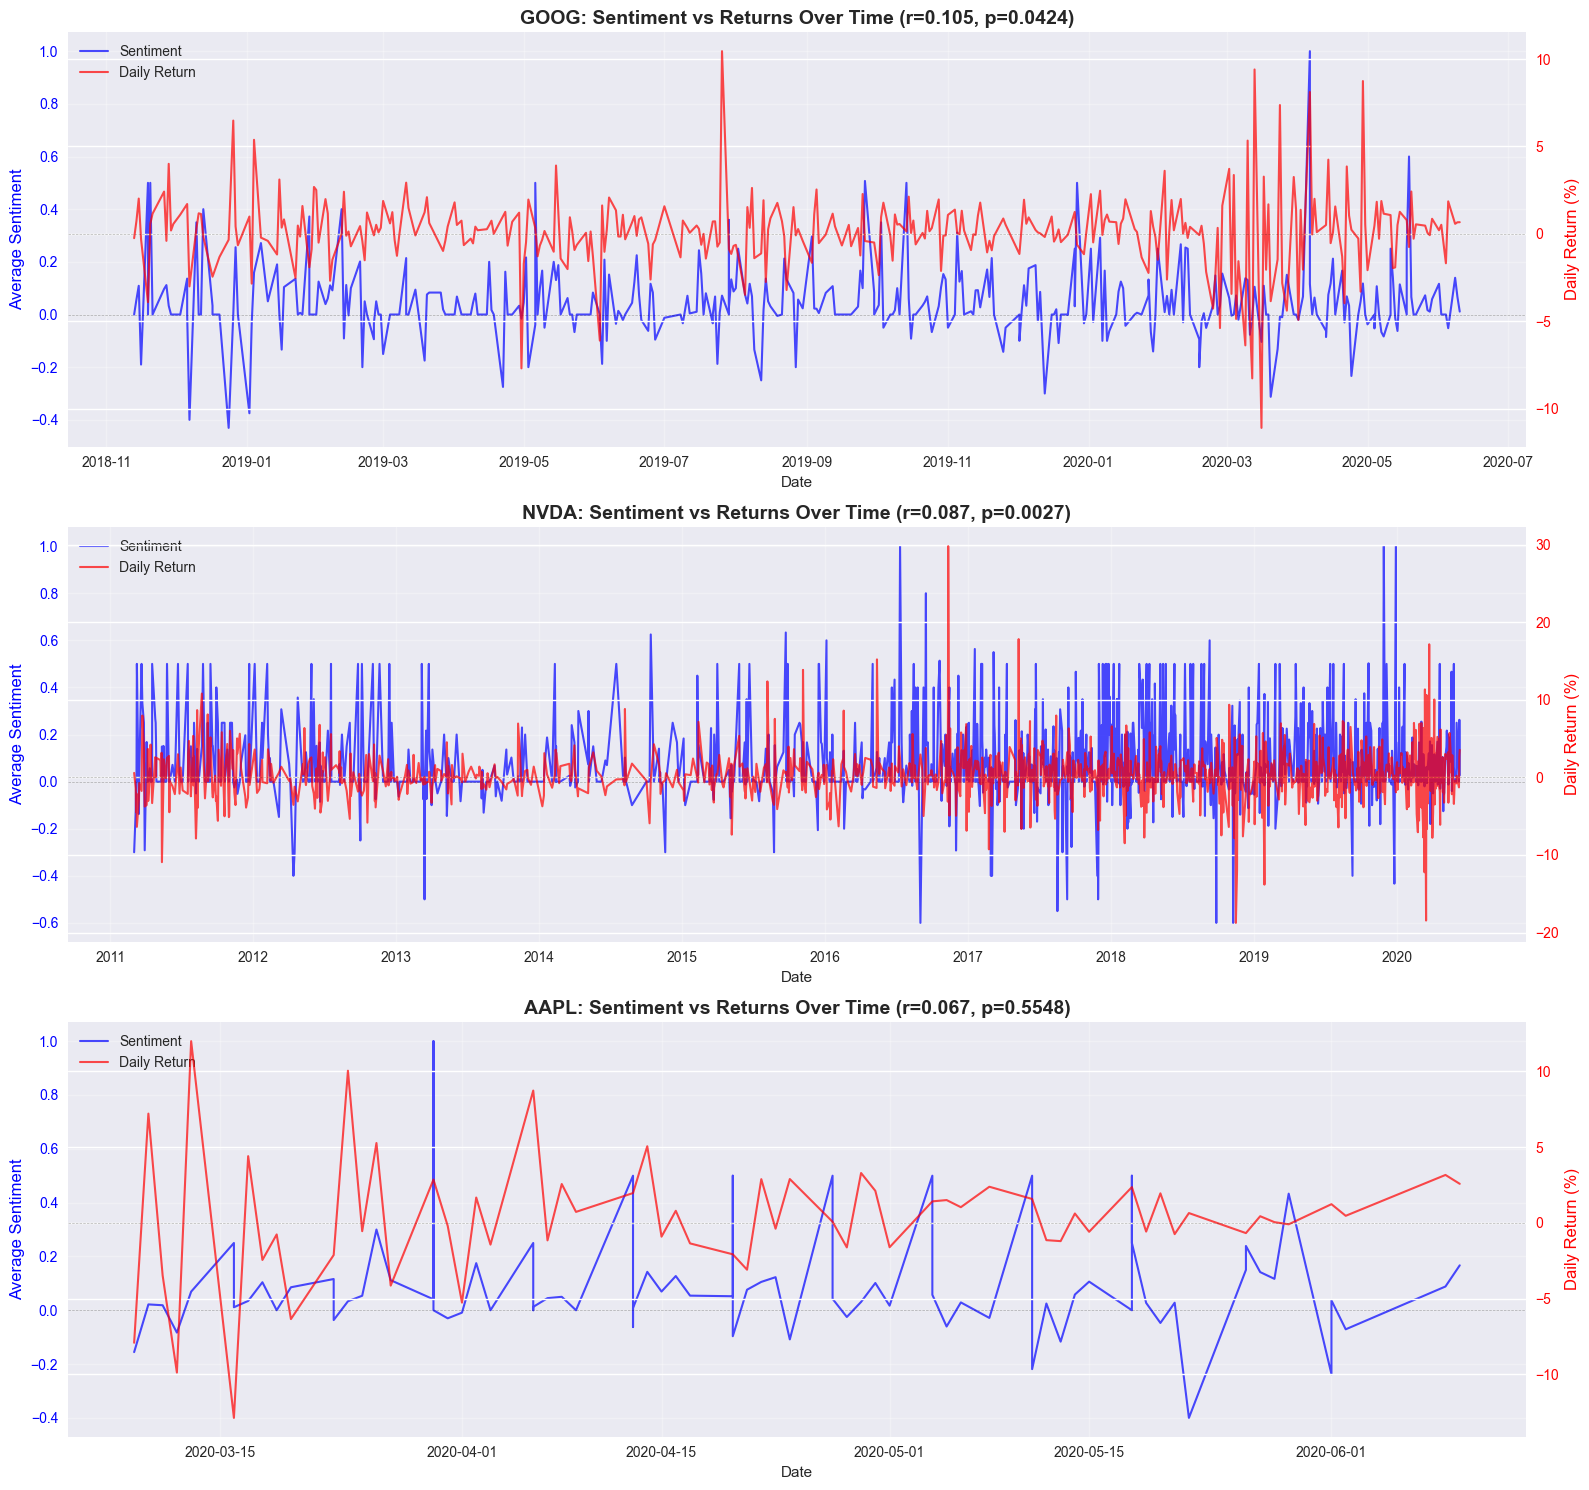

In [31]:
# Time series visualization for top correlated stocks
if correlation_results:
    results_df = pd.DataFrame(correlation_results)
    results_df = results_df.assign(abs_correlation=results_df['correlation'].abs())
    # Get top 3 stocks by absolute correlation
    top_stocks = results_df.nlargest(3, 'abs_correlation')['stock'].tolist()
    top_stocks = [stock for stock in top_stocks if stock in merged_data_all]
    
    if top_stocks:
        fig, axes = plt.subplots(len(top_stocks), 1, figsize=(16, 5*len(top_stocks)))
        if len(top_stocks) == 1:
            axes = [axes]
        
        for idx, stock in enumerate(top_stocks):
            merged = merged_data_all[stock].sort_values('date')
            
            ax1 = axes[idx]
            ax2 = ax1.twinx()
            
            # Plot sentiment
            line1 = ax1.plot(merged['date'], merged['avg_sentiment'], 
                            color='blue', alpha=0.7, linewidth=1.5, label='Sentiment')
            ax1.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.3)
            ax1.set_ylabel('Average Sentiment', color='blue', fontsize=12)
            ax1.tick_params(axis='y', labelcolor='blue')
            ax1.grid(alpha=0.3)
            
            # Plot returns
            line2 = ax2.plot(merged['date'], merged['daily_return'], 
                            color='red', alpha=0.7, linewidth=1.5, label='Daily Return')
            ax2.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.3)
            ax2.set_ylabel('Daily Return (%)', color='red', fontsize=12)
            ax2.tick_params(axis='y', labelcolor='red')
            
            # Combine legends
            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='upper left')
            
            corr, p_val = pearsonr(merged['avg_sentiment'], merged['daily_return'])
            ax1.set_title(f'{stock}: Sentiment vs Returns Over Time (r={corr:.3f}, p={p_val:.4f})',
                         fontsize=14, fontweight='bold')
            ax1.set_xlabel('Date')
        
        plt.tight_layout()
        plt.savefig('reports/figures/sentiment_returns_timeseries.png', dpi=300, bbox_inches='tight')
        print("✓ Saved time series plots to reports/figures/sentiment_returns_timeseries.png")
        plt.show()
    else:
        print("⚠️  No overlapping stocks available for time series visualization.")
else:
    print("⚠️  Correlation results are empty; skipping time series visualization.")


## 8. Save Processed Data


In [16]:
# Save processed data
print("\n10. SAVING PROCESSED DATA")
print("-" * 70)

from pathlib import Path
output_dir = Path("data/processed/sentiment_correlation")
output_dir.mkdir(parents=True, exist_ok=True)

# Save daily sentiment aggregated data (raw + aligned)
daily_sentiment_raw.to_csv(output_dir / "daily_sentiment_by_stock_raw.csv", index=False)
print(f"✓ Saved raw daily sentiment data: {len(daily_sentiment_raw):,} rows")

daily_sentiment_aligned.to_csv(output_dir / "daily_sentiment_by_stock.csv", index=False)
print(f"✓ Saved aligned daily sentiment data: {len(daily_sentiment_aligned):,} rows")

# Save merged data for each stock
for stock, merged in merged_data_all.items():
    merged.to_csv(output_dir / f"{stock}_sentiment_returns.csv", index=False)
    print(f"✓ Saved {stock} merged data: {len(merged):,} rows")

# Save summary statistics
summary_stats = {
    'total_articles_analyzed': len(news_df),
    'unique_stocks_in_news': news_df['stock'].nunique(),
    'date_range_news': f"{news_df['date'].min()} to {news_df['date'].max()}",
    'stocks_analyzed': list(merged_data_all.keys()),
'alignment_summary': alignment_summary.to_dict(orient='records') if not alignment_summary.empty else [],
'correlation_summary': {
    'mean': results_df['correlation'].mean() if correlation_results else None,
    'median': results_df['correlation'].median() if correlation_results else None,
    'std': results_df['correlation'].std() if correlation_results else None,
    'significant_count': (results_df['p_value'] < 0.05).sum() if correlation_results else 0,
    'avg_forward_fill_share': results_df['forward_fill_share'].mean() if correlation_results else None
}
}

import json
with open(output_dir / "analysis_summary.json", 'w') as f:
    json.dump(summary_stats, f, indent=2, default=str)
print(f"✓ Saved analysis summary")

print(f"\n✓ All data saved to {output_dir}")



10. SAVING PROCESSED DATA
----------------------------------------------------------------------
✓ Saved raw daily sentiment data: 842,010 rows
✓ Saved aligned daily sentiment data: 0 rows
✓ Saved analysis summary

✓ All data saved to data\processed\sentiment_correlation
